Original repo: https://github.com/solivr/tf-crnn

In [1]:
# get the details to make all images the same size
import os
import warnings
import numpy as np
from skimage import io as skimio
from skimage import color as skimcolor
import skimage.transform as skimtrans
import matplotlib.pyplot as plt

local_path = "/home/danny/Repos/text_recognition/tf-crnn-master/"
img_dir_old = "data/Images/"
img_dir_new = "data/Images_mod/"
trans_dir = "data/Transcriptions/"

filenames = [f.replace(".txt", "") for f in os.listdir(trans_dir)]

In [2]:
sizes = []
count = 0
for fn in filenames:
    im = skimio.imread(img_dir_old + fn + ".png")
    sizes.append(im.shape)
    if count % 1000 == 0: print(count, end = "\t")
    count += 1

0	1000	2000	3000	4000	5000	6000	7000	8000	9000	10000	11000	

In [3]:
heights = [s[0] for s in sizes]
widths = [s[1] for s in sizes]
max_height = np.max(heights)
max_width = np.max(widths)
print(max_height, max_width)
med_height = np.median(heights)
med_width = np.median(widths)
print(med_height, med_width)

408 2478
117.0 1669.0


In [4]:
with open("data/Partitions/TrainLines.lst") as f:
    training = f.read().splitlines()

with open("data/Partitions/ValidationLines.lst") as f:
    validation = f.read().splitlines()

with open("data/Partitions/TestLines.lst") as f:
    test = f.read().splitlines()

In [5]:
# read the image file
def readBenthamImg(fn, ftype=".png", img_dir_new=img_dir_new,
                   img_dir_old=img_dir_old, goal_size = (med_height, med_width)):
    im = skimio.imread(img_dir_old + fn + ftype)
    # turn all transparent pixels to background (average)
    rep_val = max(np.median(im[:,:,0]), np.mean(im[:,:,0]))
    im[im[:,:,3] == 0] = [rep_val, rep_val, rep_val, 255]
    im = skimcolor.rgb2gray(im)*255

    # make all images the same size
    size = im.shape
    if int(1.0*goal_size[1]/size[1]*size[0]) < goal_size[0]:
        new_size = (round(1.0*goal_size[1]/size[1]*size[0]), goal_size[1])
        pad_size = ((0, int(goal_size[0] - new_size[0])), (0,0))
    elif int(1.0*goal_size[0]/size[0]*size[1]) < goal_size[1]:
        new_size = (goal_size[0], round(1.0*goal_size[0]/size[0]*size[1]))
        pad_size = ((0,0), (0, int(goal_size[1] - new_size[1])))
    elif all(np.equal(size, goal_size)):
        new_size = goal_size
        pad_size = ((0,0), (0,0))
    # resize and pad based on previous calculation
    im = skimtrans.resize(im, new_size, mode="constant")
    im = np.pad(im, pad_size, mode="constant", constant_values=rep_val)
    im = im.astype("int")
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        skimio.imsave(img_dir_new + fn + ftype, im)
    return img_dir_new + fn + ftype

# read the transcription
def readBenthamTrans(fn, ftype=".txt", trans_dir=trans_dir):
    with open(trans_dir + fn + ftype, "r") as f:
        trans = f.readline()
        trans = trans.replace("\n", "")
    return trans

In [10]:
count = 0
with open("data/train.csv", "w") as f_tr, open("data/valid.csv", "w") as f_va, open("data/test.csv", "w") as f_te:
    for fn in filenames:
        new_fn = readBenthamImg(fn)
        trans = readBenthamTrans(fn)
        if fn in training:
            f_tr.write("{0};{1}\n".format(new_fn, trans))
        elif fn in validation:
            f_va.write("{0};{1}\n".format(new_fn, trans))
        elif fn in test:
            f_te.write("{0};{1}\n".format(new_fn, trans))
        if count % 1000 == 0: print(count, end = "\t")
        count += 1

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000


In [6]:
# get the alphabet
count = 0
alphabet = dict()
for fn in filenames:
    trans = readBenthamTrans(fn)
    for l in list(trans):
        if l not in alphabet:
            alphabet[l] = 0
        alphabet[l] += 1
#     t2 = list(trans)
#     alphabet.update(t2)
    if count % 1000 == 0: print(count, end="\t")
    count += 1

print()
alphabet2 = {k for k, v in alphabet.items() if v > 1}
print(len(alphabet), len(alphabet2))

alpha_string = "".join(np.sort(list(alphabet2)))
print(alpha_string)

with open("data/alphabet.txt", "w") as f:
    f.write(alpha_string)

0	1000	2000	3000	4000	5000	6000	7000	8000	9000	10000	11000	
93 88
 !"#&'()*+,-./0123456789:;<=>?ABCDEFGHIJKLMNOPQRSTUVWXY[]_abcdefghijklmnopqrstuvwxyz|£§ê


### Redo csv files

In [16]:
with open("data/Partitions/TrainLines.lst") as f:
    training = f.read().splitlines()

with open("data/Partitions/ValidationLines.lst") as f:
    validation = f.read().splitlines()

with open("data/Partitions/TestLines.lst") as f:
    test = f.read().splitlines()

local_path = "/home/danny/Repos/text_recognition/tf-crnn-master/"
count = 0
with open("data/train.csv", "w") as f_tr, open("data/valid.csv", "w") as f_va, open("data/test.csv", "w") as f_te:
    for fn in filenames:
        new_fn = local_path + img_dir_new + fn + ".png"
        trans = readBenthamTrans(fn)
        trans = trans.replace('"', '""')
        if fn in training:
            f_tr.write("{0}\t\"{1}\"\n".format(new_fn, trans))
        elif fn in validation:
            f_va.write("{0}\t\"{1}\"\n".format(new_fn, trans))
        elif fn in test:
            f_te.write("{0}\t\"{1}\"\n".format(new_fn, trans))

In [14]:
trans = 'this is my "home" you kids, you'
trans.replace('"', '\\"')

'this is my \\"home\\" you kids, you'

## In case I need to edit read fn again

(117, 1669)
(117.0, 1669.0)
((0, 0), (0, 0))
(117.0, 1669.0)


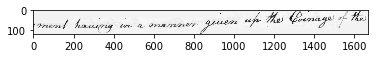

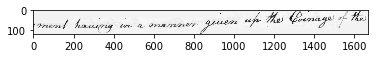

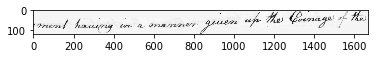

(117, 1669)
(117.0, 1669.0)
((0, 0), (0, 0))
(117.0, 1669.0)
(117, 1669)


In [8]:
fn = filenames[2930]
ftype=".png"
img_dir_new=img_dir_new
img_dir_old=img_dir_old
wpad=max_width
hpad=max_height
goal_size = (med_height, med_width)

im = skimio.imread(img_dir_old + fn + ftype)
# turn all transparent pixels to background (average)
rep_val = max(np.median(im[:,:,0]), np.mean(im[:,:,0]))
im[im[:,:,3] == 0] = [rep_val, rep_val, rep_val, 255]
im = skimcolor.rgb2gray(im)*255

# make all images the same size
size = im.shape
if int(1.0*goal_size[1]/size[1]*size[0]) < goal_size[0]:
    new_size = (round(1.0*goal_size[1]/size[1]*size[0]), goal_size[1])
    pad_size = ((0, int(goal_size[0] - new_size[0])), (0,0))
elif int(1.0*goal_size[0]/size[0]*size[1]) < goal_size[1]:
    new_size = (goal_size[0], round(1.0*goal_size[0]/size[0]*size[1]))
    pad_size = ((0,0), (0, int(goal_size[1] - new_size[1])))
elif all(np.equal(size, goal_size)):
    new_size = goal_size
    pad_size = ((0,0), (0,0))
# resize and pad based on previous calculation
im2 = skimtrans.resize(im, new_size, mode="constant")
print(size)
print(new_size)
print(pad_size)
print(goal_size)
im3 = np.pad(im2, pad_size, mode="constant", constant_values=rep_val).astype("int")

plt.imshow(im, cmap="gray"); plt.show()
plt.imshow(im2, cmap="gray"); plt.show()
plt.imshow(im3, cmap="gray"); plt.show()

print(size)
print(new_size)
print(pad_size)
print(goal_size)
print(im3.shape)
# im3.astype("int")
# skimio.imsave(img_dir_new + fn + ftype, im)
# return img_dir_new + fn + ftype